# **Técnicas Avanzadas de Aprendizaje**

##Estimación de precios de inmuebles##

###Fabio Santamaría Iglesias###

28 de junio de 2021

---

Disponemos de un dataset con información de inmuebles vendidos en el Condado de King, incluida la ciudad de Seattle, entre mayo de 2014 y mayo de 2015.

El objetivo de la práctica consiste en utilizar un árbol de decisión, un modelo Random Forest y el algoritmo Gradient Boosting vistos en el módulo para la estimación de los precios de venta de inmuebles en este condado y para esas fechas.


# Preparación del entorno

Importamos los paquetes necesarios:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import re
import matplotlib.pyplot as plt

# Dataset

Las variables son las siguientes: 

- Id: identificador del inmueble. 
- Date: fecha de venta en formato “YYYYMMDDT000000”. 
- Price: precio de venta final en $. 
- Bedrooms: número de habitaciones del inmueble. 
- Bathrooms: número de aseos del inmueble. 
- Sqft_living: área del inmueble en pies cuadrados. 
- Sqft_lot: área de la parcela en la que se encuentra. 
- Floors: número de pisos del inmueble. 
- Waterfront: valor = 0 si no tiene vistas al mar; valor = 1 si tiene vistas al mar. 
- View: nos dice si ha sido visitada por potenciales compradores muchas o pocas veces (0 pocas, 4 muchas). 
- Condition: condición en la que se encuentra el inmueble (1 mal, 5 muy bien). 
- Grade: calificación dada al inmueble, basada en un sistema propio del Condado de King (cuanto mayor es el valor, mejor es el inmueble). 
- Sqft_above: área en pies cuadrados del inmueble si no contamos el sótano. 
- Sqft_basement: área en pies cuadrados del sótano. 
- Yr_built: año de construcción. 
- Yr_renovated: año en que fue reformado/restaurado. 
- Zipcode: parecido al código postal español. 
- Lat: latitud en grados. 
- Lon: longitud en grados. 
- Sqft_living: área media de los 15 inmuebles vecinos más cercanos. 
- Sqft_lot15: área media de las 15 parcelas vecinas más cercanas. 




Lo primero es crear el acceso a *Google Drive* para luego importar los datos:

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Almacenamos los datos contenidos en el .csv en un *dataframe*:

In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/Modulo 6/act4_kc_house_data.csv"
df_ini = pd.read_csv(path, parse_dates=['date'])
print(df_ini.shape)
df_ini.head(3)

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


Observamos que hemos importado 21613 registros y que las variables son de diferente tipo:

In [5]:
df_ini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

A continuación, buscamos si hay valores faltantes:

In [6]:
np.sum(df_ini.isnull())

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

o valores duplicados:

In [11]:
df_ini.duplicated().any()

False

Como vemos, disponemos de un conjunto de datos completo sin duplicidades.

#Preprocesado

Antes de comenzar a modelizar, es necesario preparar el conjunto de datos. Con esta finalidad, aplicaremos las siguientes transformaciones:

* Convertir las áreas a metros cuadrados. 

* Convertir la fecha de venta en string “YYYYMMDD”. 



In [ ]:
df_all = df_ini.copy(deep=True)

#convertir sqft a sqm
sqftToSqm = 0.092903
df_all.loc[:, df_all.columns.str.startswith('sqft')] = df_all.loc[:, df_all.columns.str.startswith('sqft')].apply(lambda x: x*sqftToSqm)
df_all.rename(columns=lambda x: re.sub('sqft*','sqm',x), inplace=True)

#convertir fecha a str
df_all['date'] = df_all['date'].dt.strftime('%Y%m%d')

df_all.head(3)

,id,date,price,bedrooms,bathrooms,sqm_living,sqm_lot,floors,waterfront,view,condition,grade,sqm_above,sqm_basement,yr_built,yr_renovated,zipcode,lat,long,sqm_living15,sqm_lot15
0,7129300520,20141013,221900.0,3,1.00,109.62554,524.901950,1.0,0,0,3,7,109.62554,0.0000,1955,0,98178,47.5112,-122.257,124.49002,524.901950
1,6414100192,20141209,538000.0,3,2.25,238.76071,672.803526,2.0,0,0,3,7,201.59951,37.1612,1951,1991,98125,47.7210,-122.319,157.00607,709.686017
2,5631500400,20150225,180000.0,2,1.00,71.53531,929.030000,1.0,0,0,3,6,71.53531,0.0000,1933,0,98028,47.7379,-122.233,252.69616,748.983986


Se han transformado todas las columnas que empiezan con la cadena *sqft* (square feet) y se han renombrado a *sqm* (square meter). Además, se ha convertido la fecha a tipo string siguiendo el formato americano.

#Estimación de precios

A continuación, seleccionamos las variables predictoras y construimos los subconjuntos train (70%) y test (30%):

In [ ]:
X = df_all.drop(['id', 'price'], axis=1)
y = df_all['price']

Se ha descartado la variable *id* ya que no aporta información relevante.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    random_state=42, test_size=0.3)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(15129, 19) (15129,)
(6484, 19) (6484,)


Ya estamos en condiciones de realizar los diferentes modelizados.

## Árbol de decisión

Empezamos realizando un árbol de decisión. Para seleccionar cuál es el modelo óptimo, entrenamos varios con distintas profundidades. Después, predecimos los resultados y calculamos el score tanto para el conjunto train como para el test.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

In [ ]:
md_list = []
score_train_list = []
score_test_list = []


for maxdepth in list(range(1,30,2)):
  tree_model = DecisionTreeRegressor(random_state=0, max_depth=maxdepth)
  tree_model.fit(X_train, y_train)

  pred_train = tree_model.predict(X_train)
  pred_test = tree_model.predict(X_test)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*tree_model.score(X_train, y_train))
  score_test_list.append(100.0*tree_model.score(X_test, y_test))

df_model_max_depth = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list
                   })

df_model_max_depth.set_index("max_depth", inplace=True)

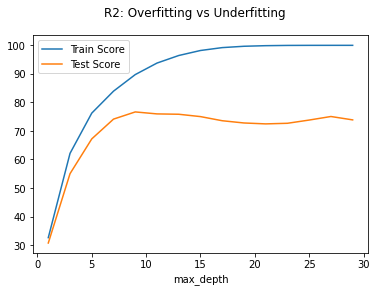

In [ ]:
df_model_max_depth["score_train"].plot(label="Train Score")
df_model_max_depth["score_test"].plot(label="Test Score")
plt.suptitle("R2: Overfitting vs Underfitting")
plt.legend()
plt.show();

Para el conjunto de entrenamiento, conforme la profundidad aumenta, el $R^2$ mejora. De hecho, para valores altos, la *accuracy* alcanzada es de casi el 100%.

Por su parte, en el conjunto test el indicador $R^2$ crece hasta que la profundidad del árbol alcanza los 10 niveles. A partir de este valor, la *accuracy* se estanca alrededor del 75%.

Como vemos, para valores pequeños, inferiores a una profundidad de 10, los modelos no son lo suficientemente complejos para funcionar todo lo bien que podrían. Se dice por tanto que presentan *underfitting*.

Por otro lado, con más de 10 niveles de profundidad el comportamiento en ambos subconjuntos comienza a diferir. Mientras que a mayor profundidad observamos como el árbol se va ajustando cada vez mejor al conjunto de entrenamiento, para el conjunto de prueba, esta mejorar se estanca. Por esta razón, se indica que estos modelos manifiestan *overfitting*.

El modelo óptimo es aquel que escapa del *underfitting* y el *overfitting*, siendo el más sencillo posible con el mejor comportamiento en el conjunto test. En nuestro caso, esto ocurre para el valor *max_depth = 9*:

In [ ]:
df_model_max_depth[df_model_max_depth.score_test == df_model_max_depth.score_test.max()]

,score_train,score_test
max_depth,,
9,89.750767,76.667265


De esta forma, construimos nuestro árbol de decisión final con dicha profundidad:

In [ ]:
tree_model_final = DecisionTreeRegressor(random_state=0, max_depth=9)
tree_model_final.fit(X_train, y_train)

print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*tree_model_final.score(X_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*tree_model_final.score(X_test, y_test)))

Precisión sobre los datos de entrenamiento: 89.75
Precisión sobre los datos de test: 76.67


Uno de resultados más interesantes en un problema de regresión como este es poder conocer la importancia de las variables predictoras. Esta información está contenida en el atributo *feature_importances_* de nuestro modelo y se puede representar gráficamente:

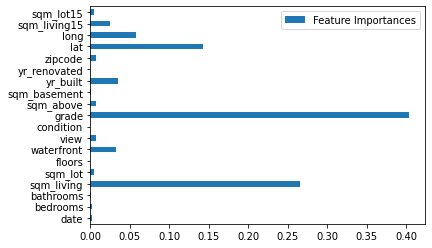

In [ ]:
df_imp = pd.DataFrame(tree_model_final.feature_importances_.reshape(1,-1), columns=X.columns, index=["Feature Importances"])
df_imp.T.plot.barh()
plt.legend()
plt.show();

Como vemos, la valoración otorgada por el ayuntamiento (*grade*) y los metros cuadrados del inmnueble (*sqm_living*) son las variables más importantes de nuestro modelo.

## Random Forest

A continuación, buscaremos un algoritmo de *Random Forest* adecuado para tratar de predecir el precio de las viviendas.

Estos modelos no son más que un conjunto de árboles de decisión trabajando en paralelo. Estos árboles son diferentes entre sí, ya que cada uno se entrena de forma distinta. Por un lado, se juega con las variables predictoras en cada ramificación de cada árbol. Por otro, cada árbol se entrena con un subconjunto diferente del conjunto de entrenamiento. Por último, para obtener la predicción final, se agregan los resultados de todos los árboles.

Jugaremos tanto con la profundidad de los árboles como con el número de estos  para tratar de encontrar el modelo óptimo. Así, primero probamos a usar diferentes profundidades con modelos con 10 árboles de decisión:

In [ ]:
from sklearn.ensemble import RandomForestRegressor

md_list = []
score_train_list = []
score_test_list = []

for maxdepth in list(range(1, 15)):
  rf_model = RandomForestRegressor(random_state=0, max_depth=maxdepth, n_estimators = 10, n_jobs=-1)
  rf_model.fit(X_train, y_train)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*rf_model.score(X_train, y_train))
  score_test_list.append(100.0*rf_model.score(X_test, y_test))

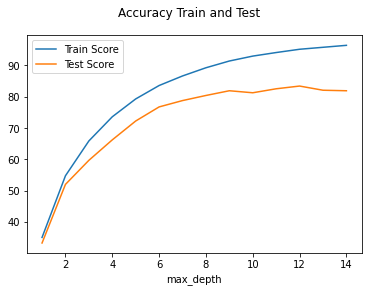

In [ ]:
df = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list})

df.set_index("max_depth", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

La gráfica obtenida es muy similar a la observada en el modelo de árbol de decisión. El análisis y las conclusiones son idénticas, debemos buscar el valor más pequeño de la profundidad que maximice el comportamiento en el conjunto test:

In [ ]:
df[df.score_test == df.score_test.max()]

,score_train,score_test
max_depth,,
12,95.178144,83.41899


Se obtiene un valor *max_depth = 12*, mayor que el *max_depth = 9* para el árbol de decisión. Asimismo, el *accuracy* en el conjunto test es superior. En principio, esto puede deberse a que el algoritmo *Random Forest* es más resistente al *overfitting* y soporta mejor árboles más complejos que pueden mejorar el $R^2$.

A continuación, para el mejor valor de profundidad, variamos el número de estimadores, es decir, el número de árboles de decisión que trabajan en paralelo en nuestro *Random Forest*:

In [ ]:
n_estimators_list = []
score_train_list = []
score_test_list = []

for n_estimators in list(range(10,100,10)):
  rf_model = RandomForestRegressor(random_state=0, n_estimators = n_estimators, max_depth=12, n_jobs=-1)
  rf_model.fit(X_train, y_train)

  ## Generación de listas
  n_estimators_list.append(n_estimators)
  score_train_list.append(100.0*rf_model.score(X_train, y_train))
  score_test_list.append(100.0*rf_model.score(X_test, y_test))

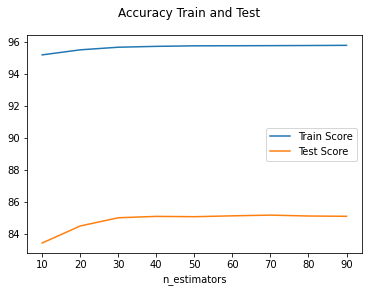

In [ ]:
df = pd.DataFrame({"n_estimators":n_estimators_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list})

df.set_index("n_estimators", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

El $R^2$ mejora levemente conforme aumenta el número de árboles de decisión hasta hacerse plano para un determinado valor. En concreto, para el conjunto test, podemos observar que a partir de 40 estimadores no hay una mejora significativa.

Como el número de estimadores es proporcional a la cantidad de recursos necesarios para entrenar y predecir con nuestro algoritmo, es conveniente elegir el mínimo posible manteniendo en lo preferible un buen comportamiento. Teniendo esto en cuenta, decidimos usar *n_estimartors = 40*.

Dicho todo esto, creamos nuestro modelo *Random Forest* definitivo:

In [ ]:
rf_model_final = RandomForestRegressor(random_state=0, n_estimators = 40, max_depth=12, n_jobs=-1)
rf_model_final.fit(X_train, y_train)

print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*rf_model_final.score(X_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*rf_model_final.score(X_test, y_test)))

Precisión sobre los datos de entrenamiento: 95.71
Precisión sobre los datos de test: 85.08


Al igual que hicimos con el árbol de decisión, podemos intentar ver las variables más relevantes a la hora de influir en el precio de un inmueble:

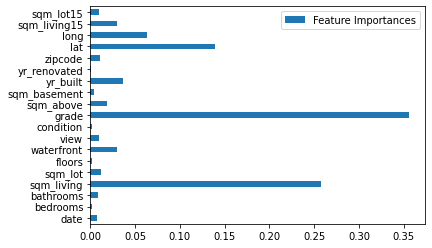

In [ ]:
df_imp = pd.DataFrame(rf_model_final.feature_importances_.reshape(1,-1), columns=X.columns, index=["Feature Importances"])
df_imp.T.plot.barh()
plt.legend()
plt.show();

Se obtiene un resultado muy similar, con *grade* y *sqm_living* jugando el papel más importante.

Si nos fijamos, vemos que variables que el árbol de decisión había desechado casi por completo, como *date*, *bethrooms*, *sqm_lot*, etc... son más relevantes. En el apartado de conclusiones analizaremos por qué puede suceder esto.

## Gradient Boosting

Por último, usaremos el algoritmo *Gradient Boosting* para tratar de predecir también el precio de un inmueble.

Estos modelos están compuestos de árboles de decisión en serie. De esta forma, el primero realiza una primera aproximación sobre el conjunto de entrenamiento. Para ello, se define una función de coste que cuantifique el error. Esto permite que el siguiente árbol se entrene sobre el error obtenido en el primero. Así, conforme se van añadiendo árboles, se tiende a ir minimizando el error total cometido por el algoritmo. Por este motivo, los árboles que se usan suelen ser muy poco profundos. Para obtener la predicción final se suman las predicciones resultantes de cada árbol, a modo de aproximación perturbativa. 

Para definir el modelo entran en juego diferentes parámetros:

* max_depth: máxima profundidad de los árboles de decisión usados.

* n_estimators: número de árboles de decisión en serie que conforman el modelo

* learning_rate: peso que tiene los árboles a la hora de ir minimizando la función de coste. Cuanto mayor sea, más efecto tendrá un árbol a la hora de corrregir el error del árbol predecesor.

Tal y como hemos venido haciendo, entrenaremos diferentes modelos cambiando estos hiperparámetros con la finalidad de encontrar el mejor algoritmo que se adecue a nuestra necesidad. Comenzamos, como ya es habitual, probando profundidades distintas. Esperamos que los árboles sean muy poco profundos, así que intentamos números del 1 al 5.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
md_list = []
score_train_list = []
score_test_list = []

for maxdepth in list(range(1, 5)):

  gb_model = GradientBoostingRegressor(random_state=0, n_estimators=1000, max_depth=maxdepth, learning_rate=0.5)
  gb_model.fit(X_train, y_train)

  pred_test_gb = gb_model.predict(X_test)
  pred_train_gb = gb_model.predict(X_train)

  ## Generación de listas
  md_list.append(maxdepth)
  score_train_list.append(100.0*gb_model.score(X_train, y_train))
  score_test_list.append(100.0*gb_model.score(X_test, y_test))

df_model_max_depth = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list
                   })

df_model_max_depth.set_index("max_depth", inplace=True)

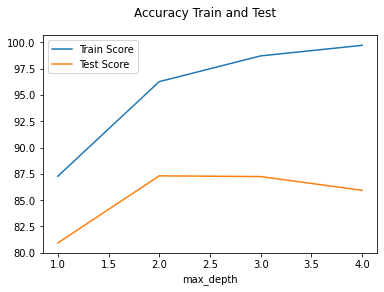

In [ ]:
df = pd.DataFrame({"max_depth":md_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list})

df.set_index("max_depth", inplace=True)
df["score_train"].plot(label="Train Score")
df["score_test"].plot(label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

Para una profundidad de un nivel observamos un $R^2$ aproximado del 80%. Si incrementamos a dos niveles, el *accuracy* alcanza el 87%. A partir de este valor, ya no se observa una mejora significativa:

In [ ]:
df

,score_train,score_test
max_depth,,
1,87.271721,80.929727
2,96.264070,87.311808
3,98.709497,87.243885
4,99.712473,85.935040


El mejor comportamiento en el conjunto de prueba se da cuando la profundidad es de 3 niveles. Elegimos este valor para los árboles de decisión de nuestro algoritmo.

El siguiente parámetro que variamos es el *learning_rate*. Probamos con 0.1, 0.3, 0.5, 0.7 y 0.9:

In [ ]:
learning_rate_list = []
score_train_list = []
score_test_list = []
best_n_AD_test_list = []
best_n_AD_train_list = []
errors_test_list = []
errors_train_list = []

for learning_rate in np.arange(0.1, 1, 0.2):

  gb_model = GradientBoostingRegressor(random_state=0, n_estimators=1000, max_depth=3, learning_rate=learning_rate)
  gb_model.fit(X_train, y_train)

  pred_test_gb = gb_model.predict(X_test)
  pred_train_gb = gb_model.predict(X_train)

  ## Generación de listas
  learning_rate_list.append(learning_rate)
  score_train_list.append(100.0*gb_model.score(X_train, y_train))
  score_test_list.append(100.0*gb_model.score(X_test, y_test))

  errors_test = [mean_squared_error(y_test, y_pred) for y_pred in gb_model.staged_predict(X_test)]
  errors_train = [mean_squared_error(y_train, y_pred) for y_pred in gb_model.staged_predict(X_train)]
  errors_test_list.append(errors_test)
  errors_train_list.append(errors_train)
  ## el mejor número de AD nos lo da el índice donde MSE es menor
  best_n_AD_test_list.append(np.argmin(errors_test))
  best_n_AD_train_list.append(np.argmin(errors_train))

df_model_learning_rate = pd.DataFrame({"learning_rate":learning_rate_list, 
                   "score_train":score_train_list,
                   "score_test":score_test_list,
                   "best_n_test":best_n_AD_test_list,
                   "best_n_train":best_n_AD_train_list
                   })

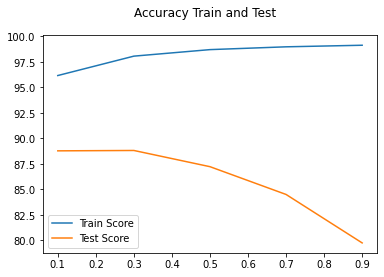

In [ ]:
plt.plot(df_model_learning_rate["learning_rate"], df_model_learning_rate["score_train"], label="Train Score")
plt.plot(df_model_learning_rate["learning_rate"], df_model_learning_rate["score_test"], label="Test Score")
plt.suptitle("Accuracy Train and Test")
plt.legend()
plt.show();

Aquí, hemos representado la *accuracy* frente al *learning_rate*. Como vemos, conforme vamos aumentando la importancia de las correciones de los árboles sucesivos, el $R^2$ va disminuyendo en el conjunto de prueba y aumentando en el conjunto de entrenamiento, adentrándonos en la zona de *overfitting*. No obstante, para poder tomar una decisión sobre el valor de aprendizaje adecuado, observemos con cuántos estimadores obtenemos el menor error en el cojunto de prueba: 

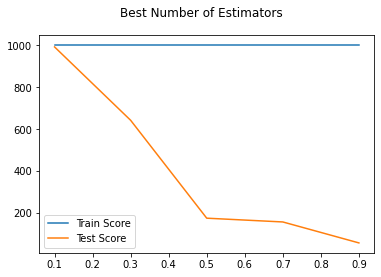

In [ ]:
plt.plot(df_model_learning_rate["learning_rate"], df_model_learning_rate["best_n_train"], label="Train Score")
plt.plot(df_model_learning_rate["learning_rate"], df_model_learning_rate["best_n_test"], label="Test Score")
plt.suptitle("Best Number of Estimators")
plt.legend()
plt.show();

Por un lado, el conjunto de entrenamiento va mejorando con cada último estimador. Por el otro, en el conjunto de prueba se ve como a un mayor *learning_rate* menor número de estimadores necesitamos.

El caso ideal es el de learning rate bajo y número de árboles de decisión alto. Aunque esto lleva a modelos muy lentos de entrenar. En nuestro caso, **elegimos como valor óptimo un learning_rate = 0.5**, pues, si bien la *accuracy* es similar a los valores 0.1 o 0.3 (aproximadamente 87%), el número de estimadores necesarios es significativamente menor.

De esta forma, tras un ajuste meticuloso y más elaborado en comparación con el resto de modelos, llegamos a nuestro algoritmo final:


In [ ]:
gb_model_final = GradientBoostingRegressor(random_state=0, n_estimators=250, max_depth=3, learning_rate=0.5)
gb_model_final.fit(X_train, y_train)

pred_test_gb = gb_model_final.predict(X_test)
pred_train_gb = gb_model_final.predict(X_train)

print("Precisión sobre los datos de entrenamiento: {:.2f}".format(100.0*gb_model_final.score(X_train, y_train)))
print("Precisión sobre los datos de test: {:.2f}".format(100.0*gb_model_final.score(X_test, y_test)))

Precisión sobre los datos de entrenamiento: 96.66
Precisión sobre los datos de test: 87.61


La *accuracy* final de nuestro modelo es de 87,61% en el conjunto de prueba, un mejor resultado comparado con el algoritmo *Random Forest* (85.08%) y el árbol de decisión (76.67%).

Este modelo también nos ofrece la posibilidad de ver cuáles son las variables más relevantes a la hora de influir en el precio de un inmueble:

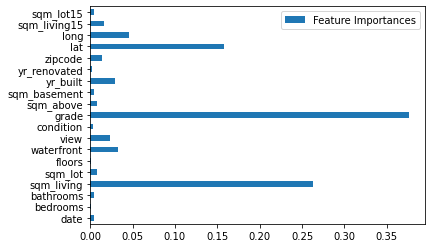

In [ ]:
df_imp = pd.DataFrame(gb_model_final.feature_importances_.reshape(1,-1), columns=X.columns, index=["Feature Importances"])
df_imp.T.plot.barh()
plt.legend()
plt.show();

El parámetro *grade* y *sqm_living* siguen jugando el papel más importante. El gráfico es muy similar al obtenido con el resto de modelos.

# **Conclusiones**





En esta tarea se han usado diferentes algoritmos para tratar de predecir el precio de un inmueble en base a sus características. En la siguiente tabla, resumimos los resultados obtenidos: 

|    Modelo  | $R^2$ (sobre el subconjunto de prueba) |
|---------------|:-------------:|
|   *Árbol de decisión (max_depth=9)*    |      76,67    |
|   *Random Forest (n_estimators = 40, max_depth=12)*        |      85,08    |
|   *Gradient Boosting (n_estimators=250, max_depth=3, learning_rate=0.5)*    |     87,61     |


Así, para el árbol de decisión más óptimo que hemos encontrado se ha obtenido el peor resultado de todos, mientras que con el algoritmo de *Gradient Boosting* hemos conseguido la mejor capacidad predictiva. No obstante, encontrar el mejor modelo *Gradient Boosting* ha exigido una búsqueda mucho más intensiva que en cualquier otro, teniendo que ajustar 3 hiperparámetros de una forma mucho más delicada y exhaustiva.

En cuanto a las variables, hemos visto cómo todos los modelos concuerdan en que *grade* y *sqm_living* (orginalmente *sqrf_living*) son las más relevantes. Las diferencias más grandes aquí se observan en el *Random Forest*, pues da más importancia a variables que en el resto de modelos llegan a ser incluso descartadas. La teoría nos dice que esto se debe al bagging, la elección de variables predictoras que se hace en cada split de cada árbol. En esencia, este mecanismo fuerza a que los árboles sean diferentes restringiendo de forma distinta la cantidad de variables que pueden ser usadas. Por lo tanto, existe la posibilidad de que haya árboles de decisión que, por azar, se hayan construido con variables muy poco relevantes. Es por ello que al final estas variables pueden verse sobrerrepresentadas en importancia.

En conclusión, el árbol de decisión es el modelo más simple, y por ende el que mejor se puede interpretar, pero es el que peor predice. *Random Forest* es más complejo, permitiendo una mejora significativa en el poder predictivo acosta de perder interpretabilidad. Por último, *Gradient Boosting* es el que mejor predice. Sin embargo, también es el que más trabajo requiere a la hora de ajustar sus hiperparámetros.